# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [756]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import struct
from array import array

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

#We use Struct to unpack the binary data structure
def load(path_img, path_lbl):
        with open(path_lbl, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Expected 2049 got {}'.format(magic))
            labels = array("B", file.read())

        with open(path_img, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Expected 2051 got {}'.format(magic))

            image_data = array("B", file.read())

        images = []
        print("loaind {} images".format(size))
        for i in range(size):
            images.append([0] * rows * cols)

        for i in range(size):
            images[i][:] = image_data[i*rows*cols:(i + 1) * rows * cols]

        return images, labels

train_dataset, train_labels = load('train-images-idx3-ubyte','train-labels-idx1-ubyte')
test_dataset, test_labels = load('t10k-images-idx3-ubyte','t10k-labels-idx1-ubyte')


loaind 60000 images
loaind 10000 images


In [757]:
from sklearn.model_selection import train_test_split
train, validation, t_labels, v_labels = train_test_split(train_dataset, train_labels, test_size=0.33, random_state=42)

(28, 28)
3


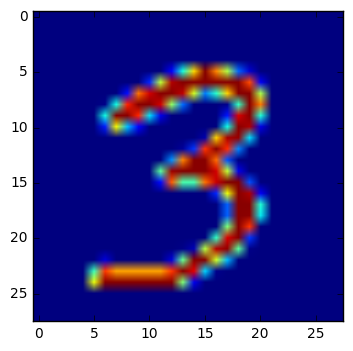

In [758]:
index = 999
img = np.asarray(train[index]).reshape(28,28)
plt.imshow(img)
print(img.shape)
print(bytes(t_labels[index]).decode('utf-8'))

In [759]:
def concat_images(imga, imgb):
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img


In [760]:
from scipy import ndimage
from scipy.misc import imresize
import random

IMAGE_SIZE = 28
NUM_CHANNELS = 1
NUM_LABELS = 11 # 0-9 and no digit (10)
N = 5 # max number of digits on the sequence

np.random.seed(42)
  
def create_sequences(images, labels):
  
  #if type(train_labels[0]).__module__ == np.__name__:
  #  print('Sequence already created')
  #  return images, labels
  
  length = len(images)
  index = 0
  seq_images = np.ndarray([length,IMAGE_SIZE,IMAGE_SIZE*N,NUM_CHANNELS], dtype='float32')
  seq_labels = np.ones([length, N], dtype=int) * 10 # init to 10 cause it would be no digit
  black = np.asarray([[0]*IMAGE_SIZE for _ in range (0,IMAGE_SIZE)])
  black = (black/125.5)-1
  while index < length:
    # Random
    L = random.randint(1, N)
    # Image
    selected = []
    for k in range(0,N-L):
        selected.append(black)
    i=0
    while i<L:
        offset = random.randint(0, length-N)
        im = np.asarray(images[offset]).reshape(28,28)
        im = (im/125.5)-1
        selected.append(im)
        seq_labels[index,N-L+i]=labels[offset]
        i=i+1
    sequence = np.hstack(selected)
    sequence_resized = imresize(sequence, (28,28*N)) #28x28
    sequence_resized = sequence_resized.reshape((28, 28*N, NUM_CHANNELS)).astype(np.float32) #28x28x1
    
    seq_images[index] = sequence_resized
      
    index += 1
      
  return seq_images, seq_labels

In [761]:

strain_dataset, st_labels = create_sequences(train, t_labels)
svalid_dataset, sv_labels = create_sequences(validation, v_labels)

stest_dataset,stest_labels = create_sequences(test_dataset,test_labels)

[10 10  1  8  2]


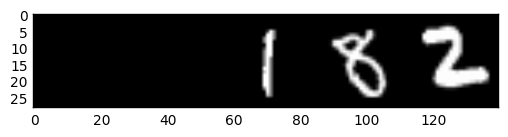

In [762]:
index = 11
print(sv_labels[index])
im = svalid_dataset[index].reshape(28,28*N)
plt.imshow(im,cmap='gray')
plt.show()
#test_dataset, test_labels = create_sequences(test_dataset, test_labels)

#print('Training set', strain_dataset.shape, st_labels.shape)
#print('Validation set', valid_dataset.shape, valid_labels.shape)
#print('Test set', test_dataset.shape, test_labels.shape)  

In [763]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D,Flatten,Dropout,Input
from keras.layers.pooling import MaxPooling2D
from keras.models import load_model
from IPython.display import SVG
from keras.models import Model
from keras.utils.np_utils import to_categorical
try:
    model = load_model("mnist_cnn.h5")
except:
    model = None
x = Input((28, 28*N,1))

#model.add(Dense(output_dim=64, input_dim=100))
y = Convolution2D(8, 3, 3, activation="relu", border_mode="same")(x)
y = MaxPooling2D((2, 2))(y)
y = Convolution2D(16, 3, 3, border_mode="same", activation="relu")(y)
y = MaxPooling2D((2, 2))(y)

y = Flatten()(y)
y = Dense(128, activation="relu")(y)

digit1 = Dense(11, activation="softmax")(y)
digit2 = Dense(11, activation="softmax")(y)
digit3 = Dense(11, activation="softmax")(y)
digit4 = Dense(11, activation="softmax")(y)
digit5 = Dense(11, activation="softmax")(y)
if not model:
    model = Model(input=x, output=[digit1, digit2, digit3,digit4,digit5])
    model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
print(model.layers[0].output_shape)
print(model.layers[1].output_shape)
print(model.layers[2].output_shape)
print(model.layers[3].output_shape)
print(model.layers[4].output_shape)

train_labels = [to_categorical(st_labels[:,0],11),
                to_categorical(st_labels[:,1],11),
                to_categorical(st_labels[:,2],11),
                to_categorical(st_labels[:,3],11),
                to_categorical(st_labels[:,4],11)]
validation_labels = [to_categorical(sv_labels[:,0],11),
                     to_categorical(sv_labels[:,1],11),
                     to_categorical(sv_labels[:,2],11),
                     to_categorical(sv_labels[:,3],11),
                     to_categorical(sv_labels[:,4],11)]

#print(len(train_labels[0]))
#print(sv_train.shape)

model.fit(strain_dataset, train_labels, nb_epoch=3, batch_size=64,validation_data=(svalid_dataset, validation_labels))

(None, 28, 140, 1)
(None, 28, 140, 8)
(None, 14, 70, 8)
(None, 14, 70, 16)
(None, 7, 35, 16)
Train on 40200 samples, validate on 19800 samples
Epoch 1/3
40200/40200 [==============================] - 120s - loss: 3.8994 - dense_365_loss: 0.4362 - dense_366_loss: 0.9769 - dense_367_loss: 0.7626 - dense_368_loss: 0.8634 - dense_369_loss: 0.8603 - dense_365_acc: 0.9183 - dense_366_acc: 0.8530 - dense_367_acc: 0.8479 - dense_368_acc: 0.8299 - dense_369_acc: 0.8158 - val_loss: 0.6850 - val_dense_365_loss: 0.0860 - val_dense_366_loss: 0.1133 - val_dense_367_loss: 0.1440 - val_dense_368_loss: 0.1512 - val_dense_369_loss: 0.1906 - val_dense_365_acc: 0.9749 - val_dense_366_acc: 0.9657 - val_dense_367_acc: 0.9551 - val_dense_368_acc: 0.9507 - val_dense_369_acc: 0.9430
Epoch 2/3
40200/40200 [==============================] - 117s - loss: 0.4327 - dense_365_loss: 0.0482 - dense_366_loss: 0.0721 - dense_367_loss: 0.0892 - dense_368_loss: 0.1076 - dense_369_loss: 0.1156 - dense_365_acc: 0.9853 - den

In [764]:
model.save("mnist_cnn.h5")

In [765]:

SeqTest_lbels = [to_categorical(stest_labels[:,0],11),
                 to_categorical(stest_labels[:,1],11),
                 to_categorical(stest_labels[:,2],11),
                 to_categorical(stest_labels[:,3],11),
                 to_categorical(stest_labels[:,4],11)]

model.evaluate(stest_dataset,SeqTest_lbels)

10000/10000 [==============================] - 10s    


[0.53576314700841898,
 0.060086464781643006,
 0.087952816439396703,
 0.088206190957664507,
 0.14104039932135493,
 0.15847727680951357,
 0.98550000000000004,
 0.97670000000000001,
 0.97370000000000001,
 0.96109999999999995,
 0.95669999999999999]

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 
At first I wondered if it was better to approach the problem through a network capable of recognizing a single digit and use it through a sliding window in order to identify sequence of digits. I have seen that in literature the problem has instead been solved through convolutional neural network capable of extracting each digit as a single feature of the same network (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.682.9111&rep=rep1&type=pdf).

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**
I have used a CNN with the following layers:
- a Convolutional layer of 8 (3x3) filters with relu Activation function;
- a 2x2 Pooling Layer
- a Convolutional layer of 16 (3x3) filters with relu Activation function;
- a 2z2 Pooling layer
- a Dense layer with 128 nodes with relu Activation function;
- five Dense parallel layers each with 11 nodes and softmax activation function;

The input image is (28,28x5), after the first convolutional layer and pooling we have 8 filters (14,70) each. After the second convolutional and pooling layers we have 16 filters (7,25) each. Then we have a Dense layer of 128 nodes which is fully connected to final five dense fostmax layers.
This gives us the five logits we can use to calculate the loss against the desired labels through the categorical_crossentropy function. 

In [766]:
model = load_model("mnist_cnn.h5")
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_64 (InputLayer)            (None, 28, 140, 1)    0                                            
____________________________________________________________________________________________________
convolution2d_143 (Convolution2D (None, 28, 140, 8)    80          input_64[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_112 (MaxPooling2D)  (None, 14, 70, 8)     0           convolution2d_143[0][0]          
____________________________________________________________________________________________________
convolution2d_144 (Convolution2D (None, 14, 70, 16)    1168        maxpooling2d_112[0][0]           
___________________________________________________________________________________________

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**
I created a dataset of sequences, with a max of 5 digits, by randomly concatenating single MNIST digit. Along with the image I created a vector of 5 integers representing the actual value the netwrok has to learn. I created three sets of images: one for training, one for validation and the last for testing. The model has been trained with batches of 64 images/labels and validated consequently.

[4 1 2 2 0]


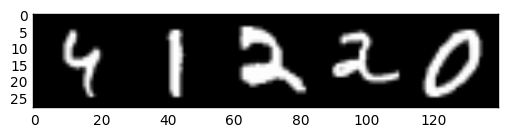

In [23]:
index = 22
print(stest_labels[index])
im = stest_dataset[index].reshape(28,28*N)
plt.imshow(im,cmap='gray')
plt.show()
array = [im.reshape(1,28,28*N,1)]

In [35]:
y_pred = model.predict(array,batch_size=1,verbose=0)
print(y_pred)
for a in y_pred:
    values = a[0].tolist()
    print(values.index(max(values)),end ="")

[array([[  1.89773459e-08,   3.96718997e-06,   5.16125418e-08,
          6.70689957e-08,   9.99591768e-01,   5.77989567e-06,
          2.75028666e-04,   1.45751846e-08,   6.97493689e-08,
          1.19584125e-04,   3.59107844e-06]], dtype=float32), array([[  9.77087282e-08,   9.99929905e-01,   1.29717064e-08,
          3.49003881e-11,   5.43213389e-07,   1.95502794e-12,
          2.31272566e-08,   1.06869010e-07,   6.90195375e-05,
          1.57537045e-07,   1.32939505e-07]], dtype=float32), array([[  1.27736770e-13,   6.79879677e-12,   9.99999881e-01,
          7.33675520e-08,   1.03594498e-12,   1.82111352e-13,
          6.20695528e-18,   3.81476006e-09,   1.24995473e-13,
          1.52026362e-12,   3.13386805e-17]], dtype=float32), array([[  5.07585196e-10,   4.94896852e-08,   9.99976277e-01,
          2.32445000e-05,   9.88802484e-10,   1.25930100e-09,
          1.24608214e-11,   3.79612175e-07,   8.29014288e-12,
          8.06305493e-08,   3.32850499e-19]], dtype=float32), array([

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [51]:
import h5py

class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']
        
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        print (" \r%d" % n ,end="")
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]
    
    def getAllDigitStructure_ByDigit(self):
        print("Loading...")
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            print (" \r%d" % i ,end="")
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result



In [719]:
train_folders = 'sv_train/train'
test_folders = 'sv_test/test'
extra_folders = 'extra'
fin = os.path.join(train_folders, 'digitStruct.mat')
dsf = DigitStructFile(fin)
train_data = dsf.getAllDigitStructure_ByDigit()
test_fin = os.path.join(test_folders, 'digitStruct.mat')
test_dsf = DigitStructFile(test_fin)
test_data = test_dsf.getAllDigitStructure_ByDigit()

Loading...
33401Loading...
13067

In [617]:
from PIL import Image
from PIL import ImageFilter
import random
train_folders = 'sv_train/train'
test_folders = 'sv_test/test'
extra_folders = 'extra'
SV_IMG_SIZE = 32
SV_CHANNELS = 3
train_imsize = np.ndarray([len(train_data),2])
k = 500
sv_images = []
max_images = 20000#len(train_data)
max_digits = 5
sv_labels = np.ones([max_images, max_digits], dtype=int) * 0 # init to 10 cause it would be no digit
nboxes = [[] for i in range(max_images)]
print ("%d to load" % len(train_data))
def getBBox(i,perc):
    '''
    Given i, the desired i.png, returns
    x_min, y_min, x_max, y_max,
    the four numbers which define the small rectangular bounding
    box that contains all individual character bounding boxes
    '''
    boxes = train_data[i]['boxes'] 
    x_min=9990
    y_min=9990
    x_max=0
    y_max=0
    for bid,b in enumerate(boxes):
        x_min = b['left'] if b['left'] <= x_min else x_min
        y_min = b['top'] if b['top'] <= y_min else y_min
        x_max = b['left']+b['width'] if  b['left']+b['width'] >= x_max else x_max
        y_max = b['top']+b['height'] if b['top']+b['height'] >= y_max else y_max
    step_x = 0 #random.random()/2*x_min
    step_y = 0 #random.random()/2*y_min
    dy = y_max-y_min
    dx = x_max-x_min
    dpy = dy*perc
    dpx = dx*perc
    nboxes[i]=[dpx+step_x,dpy+step_y,dx,dy]
    return x_min-dpx-step_x, y_min-dpy-step_y, x_max+dpx, y_max+dpy

for i in range(max_images):
    
    print (" \r%d" % i ,end="")
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    boxes = train_data[i]['boxes']
    label = [0,0,0,0,0]
    lb = len(boxes)
    if lb <= max_digits:
        im = Image.open(fullname)
        x_min, y_min, x_max, y_max = getBBox(i,0.3)
        nxmax = x_max if x_max > SV_IMG_SIZE else SV_IMG_SIZE
        nymax = y_max if y_max > SV_IMG_SIZE else SV_IMG_SIZE
        im = im.crop([x_min,y_min,nxmax,nymax])
        owidth, oheight = im.size
        wr = SV_IMG_SIZE/float(owidth)
        hr = SV_IMG_SIZE/float(oheight)
        for bid,box in  enumerate(boxes):
            sv_labels[i][max_digits-lb+bid] = int(box['label']) 
        box = nboxes[i]
        box[0]*=wr
        box[1]*=hr
        box[2]*=wr
        box[3]*=hr
        im = im.resize((SV_IMG_SIZE,SV_IMG_SIZE),Image.ANTIALIAS)
        #im = im.filter(ImageFilter.EDGE_ENHANCE_MORE)
        im = im - np.mean(im)
        array = np.asarray(im)
        array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,SV_CHANNELS)).astype(np.float32)
        na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE,1],dtype=int)
        for x in range (array.shape[0]):
            for y in range (array.shape[1]):
                na[x][y]=np.average(array[x][y][:])
        na = na.reshape(SV_IMG_SIZE,SV_IMG_SIZE,1)
        na = na.astype(np.float32)
        na = (na/125.5)-1
        #na = na - np.mean(na)
        #print(array.shape)
        sv_images.append(na)

#plt.imshow(sv_images[0])


33402 to load
19999

[0 0 1 2 8]


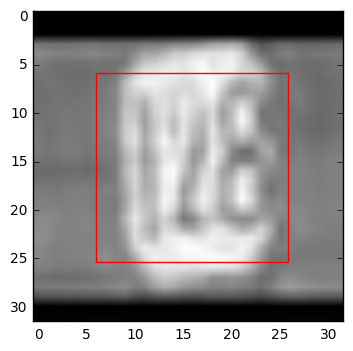

In [618]:
from matplotlib import patches
idx =8
sv_images = np.asarray(sv_images)
fig,ax = plt.subplots(1)
ax.imshow(sv_images[idx].reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
box = nboxes[idx]
rect = patches.Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
print(sv_labels[idx])

In [619]:
## from sklearn.model_selection import train_test_split
sv_train, sv_validation, svt_labels, svv_labels = train_test_split(sv_images, sv_labels, test_size=0.33, random_state=42)

In [620]:
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D,Flatten,Dropout,Input
from keras.layers.pooling import MaxPooling2D
#from keras.utils.visualize_util import plot
from IPython.display import SVG
from keras.models import Model
adam = Adam(lr=1)
SV_CHANNELS=1

try:
    model = load_model("cnn_recog.h5")
except:
    model = None
    
x = Input((SV_IMG_SIZE, SV_IMG_SIZE,SV_CHANNELS))
y = Convolution2D(4, 3, 3, activation='relu', border_mode='valid')(x)#y = MaxPooling2D((2, 2))(y)
y = Convolution2D(8, 3, 3, activation='relu', border_mode='valid')(y)
y = MaxPooling2D((2, 2))(y)
y = Dropout(0.25)(y)
y = Convolution2D(16, 3, 3, activation='relu', border_mode='valid')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Dense(128, activation='relu')(y)


digit1 = Dense(11, activation="softmax")(y)
digit2 = Dense(11, activation="softmax")(y)
digit3 = Dense(11, activation="softmax")(y)
digit4 = Dense(11, activation="softmax")(y)
digit5 = Dense(11, activation="softmax")(y)

if not model:
    model = Model(input=x, output=[digit1, digit2, digit3,digit4,digit5])
    model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    #model.summary()
sv_train_labels = [to_categorical(svt_labels[:,0],11),
                   to_categorical(svt_labels[:,1],11),
                   to_categorical(svt_labels[:,2],11),
                   to_categorical(svt_labels[:,3],11),
                   to_categorical(svt_labels[:,4],11)]
sv_validation_labels = [to_categorical(svv_labels[:,0],11),
                        to_categorical(svv_labels[:,1],11),
                        to_categorical(svv_labels[:,2],11),
                        to_categorical(svv_labels[:,3],11),
                        to_categorical(svv_labels[:,4],11)]

model.fit(sv_train, sv_train_labels, nb_epoch=30, batch_size=32,validation_data=(sv_validation, sv_validation_labels))


Train on 13400 samples, validate on 6600 samples
Epoch 1/30
13400/13400 [==============================] - 24s - loss: 6.0988 - dense_324_loss: 0.0197 - dense_325_loss: 0.2513 - dense_326_loss: 1.1775 - dense_327_loss: 2.3154 - dense_328_loss: 2.3349 - dense_324_acc: 0.9952 - dense_325_acc: 0.9540 - dense_326_acc: 0.6949 - dense_327_acc: 0.1643 - dense_328_acc: 0.1101 - val_loss: 6.2723 - val_dense_324_loss: 0.0414 - val_dense_325_loss: 0.3575 - val_dense_326_loss: 1.2617 - val_dense_327_loss: 2.3082 - val_dense_328_loss: 2.3035 - val_dense_324_acc: 0.9997 - val_dense_325_acc: 0.9558 - val_dense_326_acc: 0.6920 - val_dense_327_acc: 0.2002 - val_dense_328_acc: 0.1082
Epoch 2/30
13400/13400 [==============================] - 18s - loss: 5.7840 - dense_324_loss: 0.0030 - dense_325_loss: 0.2203 - dense_326_loss: 1.1052 - dense_327_loss: 2.2000 - dense_328_loss: 2.2555 - dense_324_acc: 0.9998 - dense_325_acc: 0.9580 - dense_326_acc: 0.7000 - dense_327_acc: 0.2580 - dense_328_acc: 0.1634 - v

In [639]:
model.save('cnn_recog.h5')

(32, 32, 1)
00021

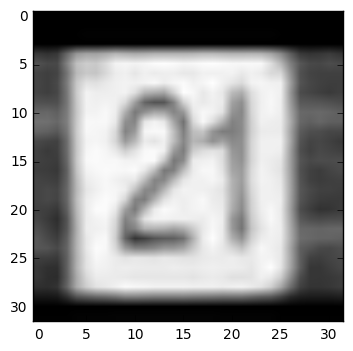

In [622]:
idx=20
fig,ax = plt.subplots(1)
im = sv_validation[idx]
print(im.shape)
y_pred = model.predict(im.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1),batch_size=1,verbose=0)
for a in y_pred:
    values = a[0].tolist()
    print(values.index(max(values)),end="")
plt.imshow(im.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')


In [753]:
svtest_labels = np.ones([max_images, max_digits], dtype=int) * 0 # init to 10 cause it would be no digit
svtest_images = []
max_images = len(test_data)

def getBBox(i,perc):
    '''
    Given i, the desired i.png, returns
    x_min, y_min, x_max, y_max,
    the four numbers which define the small rectangular bounding
    box that contains all individual character bounding boxes
    '''
    boxes = test_data[i]['boxes'] 
    x_min=9990
    y_min=9990
    x_max=0
    y_max=0
    for bid,b in enumerate(boxes):
        x_min = b['left'] if b['left'] <= x_min else x_min
        y_min = b['top'] if b['top'] <= y_min else y_min
        x_max = b['left']+b['width'] if  b['left']+b['width'] >= x_max else x_max
        y_max = b['top']+b['height'] if b['top']+b['height'] >= y_max else y_max
    step_x = 0 #random.random()/2*x_min
    step_y = 0 #random.random()/2*y_min
    dy = y_max-y_min
    dx = x_max-x_min
    dpy = dy*perc
    dpx = dx*perc
    nboxes[i]=[dpx+step_x,dpy+step_y,dx,dy]
    return x_min-dpx-step_x, y_min-dpy-step_y, x_max+dpx, y_max+dpy

for i in range(max_images):
    
    print (" \r%d" % i ,end="")
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    boxes = test_data[i]['boxes']
    label = [0,0,0,0,0]
    lb = len(boxes)
    if lb <= max_digits:
        im = Image.open(fullname)
        x_min, y_min, x_max, y_max = getBBox(i,0.3)
        nxmax = x_max if x_max > SV_IMG_SIZE else SV_IMG_SIZE
        nymax = y_max if y_max > SV_IMG_SIZE else SV_IMG_SIZE
        im = im.crop([x_min,y_min,nxmax,nymax])
        owidth, oheight = im.size
        wr = SV_IMG_SIZE/float(owidth)
        hr = SV_IMG_SIZE/float(oheight)
        for bid,box in  enumerate(boxes):
            svtest_labels[i][max_digits-lb+bid] = int(box['label']) 
        box = nboxes[i]
        box[0]*=wr
        box[1]*=hr
        box[2]*=wr
        box[3]*=hr
        im = im.resize((SV_IMG_SIZE,SV_IMG_SIZE),Image.ANTIALIAS)
        #im = im.filter(ImageFilter.EDGE_ENHANCE_MORE)
        im = im - np.mean(im)
        array = np.asarray(im)
        array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,SV_CHANNELS)).astype(np.float32)
        na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE,1],dtype=int)
        for x in range (array.shape[0]):
            for y in range (array.shape[1]):
                na[x][y]=np.average(array[x][y][:])
        na = na.reshape(SV_IMG_SIZE,SV_IMG_SIZE,1)
        na = na.astype(np.float32)
        na = (na/125.5)-1
        #na = na - np.mean(na)
        #print(array.shape)
        svtest_images.append(na)

13067

In [754]:
model = load_model("cnn_recog.h5")
SVTest_labels = [to_categorical(svtest_labels[:,0],11),
                 to_categorical(svtest_labels[:,1],11),
                 to_categorical(svtest_labels[:,2],11),
                 to_categorical(svtest_labels[:,3],11),
                 to_categorical(svtest_labels[:,4],11)]

model.evaluate(np.asarray(svtest_images),SVTest_labels)

13024/13068 [============================>.] - ETA: 0s

[2.0861711032097952,
 0.0022642750893211877,
 0.034348410577499024,
 0.28571115505779265,
 0.80957100177562891,
 0.9542762511798939,
 0.99977043158861345,
 0.99066421793694526,
 0.91521273339455156,
 0.75420875420875422,
 0.70026017755114922]

(32, 32, 1)
00009

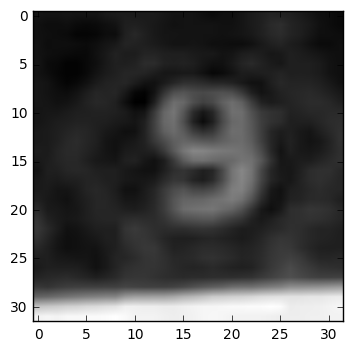

In [751]:
idx=4
fig,ax = plt.subplots(1)
im = svtest_images[idx]
print(im.shape)
y_pred = model.predict(im.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1),batch_size=1,verbose=0)
for a in y_pred:
    values = a[0].tolist()
    print(values.index(max(values)),end="")
plt.imshow(im.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')


### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**
I have used the information abot the digit boxes to infer the coordinates of the box wrapping the whole number. I have expanded the obtained coordinates to get a 30% wider box I used to crop the image. To resulting images are smaller and centered on the number. I then resize them to the desired 32X32 size. Another reduction has been made on the number of channels, from 3 RGB to 1 Gray, by averaging the RGB contributions. I have then substracted the mean value from each image. 



### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**
For a long time I have been stuck trying with a more complex CNN (i.e. more layer / nodes) that did not improve during training. Thanks to the forum suppot I understood I had to simply the network and when I did it things got far better. Basically It seems that loss tends to increase logaritmically among the epoches meaning that you can look at the first 5 epoches and get wether your model is "good" or not. 
I have also lerned that the model trains well when the input images are well centered on the house numbers..

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**
Initially a couldn't get an accuracy greater than 0.4/0.5 
After several attempts I realize there are two main aspects impacting training performances:
- the input images where not well centered on the house numbers;
and, more interesting,
- the network was too or not enough complex. 
I found that training a NN basically means find the right combination of layers, nodes, filters and so on that led to good performances. Adding too layers or nodes may cause fall in performances as well as having a netwoork with too few nodes and layers.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

(0.0, 1.0, 0.0, 1.0)

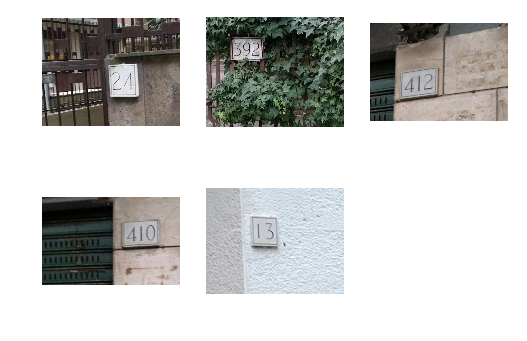

In [561]:
BIG=100
SV_IMG_SIZE=60
shot_folder="./"
files = ["shot1.jpg","shot2.jpg","shot3.jpg","shot4.jpg","shot5.jpg"]
fig,axarr = plt.subplots(2,3)
for idx,name in enumerate(files):
    fullname = os.path.join(shot_folder, name)
    img = Image.open(fullname)
    axarr[idx/3][idx%3].imshow(img)
    axarr[idx/3][idx%3].axis('off')
axarr[1][2].axis('off')

00024

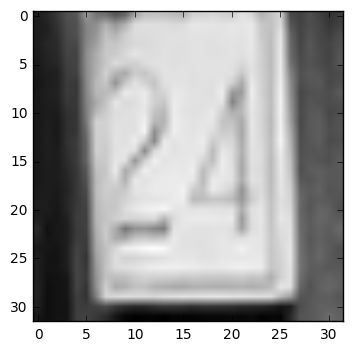

In [724]:
filename = 'shot1.jpg'
fullname = os.path.join(shot_folder, filename)
img = Image.open(fullname)
img = img.resize((BIG,BIG), Image.ANTIALIAS)
img = img.crop([43,45,75,75])
img = img.resize((SV_IMG_SIZE,SV_IMG_SIZE), Image.ANTIALIAS)
array = np.asarray(img)
array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
for x in range (array.shape[0]):
    for y in range (array.shape[1]):
        na[x][y]=np.average(array[x][y][:])
array = na.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1)
array = (array/125.5)-1
plt.imshow(array.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
y_pred = model.predict(array,batch_size=1,verbose=0)
for a in y_pred:
    values = a[0].tolist()
    print(values.index(max(values)),end="")

00392

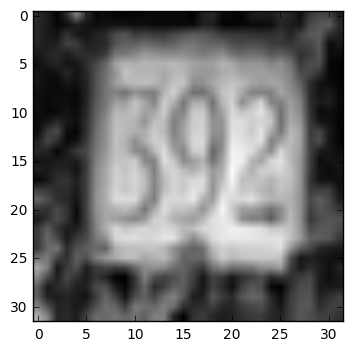

In [629]:
filename = 'shot2.jpg'
fullname = os.path.join(shot_folder, filename)
img = Image.open(fullname)
img = img.resize((BIG,BIG), Image.ANTIALIAS)
img = img.crop([12,17,45,45])
img = img.resize((SV_IMG_SIZE,SV_IMG_SIZE), Image.ANTIALIAS)
array = np.asarray(img)
array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
for x in range (array.shape[0]):
    for y in range (array.shape[1]):
        na[x][y]=np.average(array[x][y][:])
array = na.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1)
array = (array/125.5)-1
plt.imshow(array.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
y_pred = model.predict(array,batch_size=1,verbose=0)
for a in y_pred:
    values = a[0].tolist()
    print(values.index(max(values)),end="")

00112

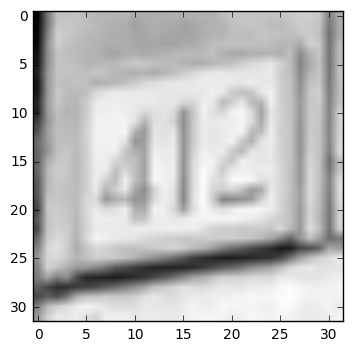

In [638]:
filename = 'shot3.jpg'
fullname = os.path.join(shot_folder, filename)
img = Image.open(fullname)
img = img.resize((BIG,BIG), Image.ANTIALIAS)
img = img.crop([17,41,55,85])
img = img.resize((SV_IMG_SIZE,SV_IMG_SIZE), Image.ANTIALIAS)
array = np.asarray(img)
array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
for x in range (array.shape[0]):
    for y in range (array.shape[1]):
        na[x][y]=np.average(array[x][y][:])
array = na.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1)
array = (array/125.5)-1
plt.imshow(array.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
y_pred = model.predict(array,batch_size=1,verbose=0)
for a in y_pred:
    values = a[0].tolist()
    print(values.index(max(values)),end="")

004110

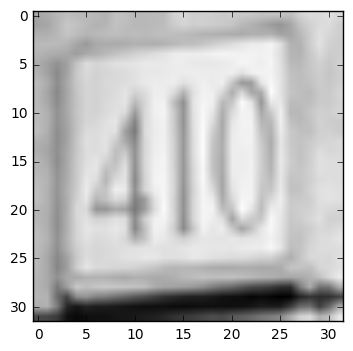

In [626]:
filename = 'shot4.jpg'
fullname = os.path.join(shot_folder, filename)
img = Image.open(fullname)
img = img.resize((BIG,BIG), Image.ANTIALIAS)
img = img.crop([55,25,90,60])
img = img.resize((SV_IMG_SIZE,SV_IMG_SIZE), Image.ANTIALIAS)
array = np.asarray(img)
array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
for x in range (array.shape[0]):
    for y in range (array.shape[1]):
        na[x][y]=np.average(array[x][y][:])
array = na.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1)
array = (array/125.5)-1
plt.imshow(array.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
y_pred = model.predict(array,batch_size=1,verbose=0)
for a in y_pred:
    values = a[0].tolist()
    print(values.index(max(values)),end="")

00013

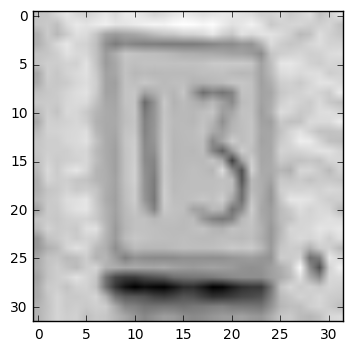

In [627]:
filename = 'shot5.jpg'
fullname = os.path.join(shot_folder, filename)
img = Image.open(fullname)
img = img.resize((BIG,BIG), Image.ANTIALIAS)
img = img.crop([25,25,60,60])
img = img.resize((SV_IMG_SIZE,SV_IMG_SIZE), Image.ANTIALIAS)
array = np.asarray(img)
array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
for x in range (array.shape[0]):
    for y in range (array.shape[1]):
        na[x][y]=np.average(array[x][y][:])
array = na.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1)
array = (array/125.5)-1
plt.imshow(array.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
y_pred = model.predict(array,batch_size=1,verbose=0)
for a in y_pred:
    values = a[0].tolist()
    print(values.index(max(values)),end="")


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**
The CNN does not perform on original images. This is reasonable since it has been trained to interpret images centered and focused on the house number. I have therefore cropped my shots on the house number and things got better. The interesting fact I notice is that the performance might depends on how well the image is centered. If the shots was few pixels wider or the house number was slightly decentered the CNN failed. This could be the expression of an overfit on that specific geometric quality of the training set.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**
I think that once the captured pictures have been transformed coherently with the training set the model performed equally.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [863]:
from PIL import Image
from PIL import ImageFilter
import random
train_folders = 'sv_train/train'
test_folders = 'test'
extra_folders = 'extra'
SV_IMG_SIZE = 32
SV_CHANNELS = 3
train_imsize = np.ndarray([len(train_data),2])
k = 500
sv_images = []
max_images = 20000#len(train_data)
max_digits = 5
sv_labels = np.ones([max_images, max_digits], dtype=int) * 0 
nboxes = [[] for i in range(max_images)]
print ("%d to load" % len(train_data))
def getBBox(i,perc):
    '''
    Given i, the desired i.png, returns
    x_min, y_min, x_max, y_max,
    the four numbers which define the small rectangular bounding
    box that contains all individual character bounding boxes
    '''
    boxes = train_data[i]['boxes'] 
    x_min=9990
    y_min=9990
    x_max=0
    y_max=0
    for bid,b in enumerate(boxes):
        x_min = b['left'] if b['left'] <= x_min else x_min
        y_min = b['top'] if b['top'] <= y_min else y_min
        x_max = b['left']+b['width'] if  b['left']+b['width'] >= x_max else x_max
        y_max = b['top']+b['height'] if b['top']+b['height'] >= y_max else y_max
    step_x = 0#x_min# (random.random()-0.5)/2*x_min
    step_y = 0#y_min# (random.random()-0.5)/2 *y_min
    dy = y_max-y_min
    dx = x_max-x_min
    dpy = dy*perc
    dpx = dx*perc
    nboxes[i]=[x_min,y_min,dx,dy]
    return x_min, y_min, x_max, y_max

for i in range(max_images):
    
    print (" \r%d" % i ,end="")
    filename = train_data[i]['filename']
    fullname = os.path.join(train_folders, filename)
    boxes = train_data[i]['boxes']
    label = [0,0,0,0,0]
    lb = len(boxes)
    if lb <= max_digits:
        im = Image.open(fullname)
        x_min, y_min, x_max, y_max = getBBox(i,1)
        nxmax = x_max# if x_max > SV_IMG_SIZE else SV_IMG_SIZE
        nymax = y_max #if y_max > SV_IMG_SIZE else SV_IMG_SIZE
        #im = im.crop([x_min,y_min,nxmax,nymax])
        owidth, oheight = im.size
        wr = SV_IMG_SIZE/float(owidth)
        hr = SV_IMG_SIZE/float(oheight)
        for bid,box in  enumerate(boxes):
            sv_labels[i][max_digits-lb+bid] = int(box['label']) 
        box = nboxes[i]
        box[0]*=wr
        box[1]*=hr
        box[2]*=wr
        box[3]*=hr
        im = im.resize((SV_IMG_SIZE,SV_IMG_SIZE),Image.ANTIALIAS)
        #im = im.filter(ImageFilter.EDGE_ENHANCE_MORE)
        im = im - np.mean(im)
        array = np.asarray(im)
        array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,SV_CHANNELS)).astype(np.float32)
        na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE,1],dtype=int)
        for x in range (array.shape[0]):
            for y in range (array.shape[1]):
                na[x][y]=np.average(array[x][y][:])
        na = na.reshape(SV_IMG_SIZE,SV_IMG_SIZE,1)
        na = na.astype(np.float32)
        na = (na/125.5)-1
        #na = na - np.mean(na)
        #print(array.shape)
        sv_images.append(na)

#plt.imshow(sv_images[0])

33402 to load
19999

[0 0 0 1 6]


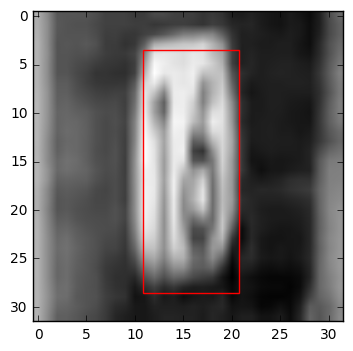

In [864]:
from matplotlib import patches
idx =9
sv_images = np.asarray(sv_images)
fig,ax = plt.subplots(1)
ax.imshow(sv_images[idx].reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
#plt.imshow(sv_images[idx].reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
box = nboxes[idx]
rect = patches.Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
print(sv_labels[idx])

In [866]:
from sklearn.model_selection import train_test_split
svb_train, svb_validation, svbt_labels, svbv_labels = train_test_split(sv_images, nboxes, test_size=0.33, random_state=42)

In [867]:
try:
    model = load_model('box_cnn.h5')
except:
    model = None

x = Input((SV_IMG_SIZE, SV_IMG_SIZE,1))
y = Convolution2D(16, 3, 3, activation="relu", border_mode="same")(x)
#y = Convolution2D(16, 3, 3, border_mode="same", activation="relu")(y)
y = MaxPooling2D((2, 2))(y)
y = Convolution2D(32, 3, 3, border_mode="same", activation="relu")(y)
y = MaxPooling2D((3, 3))(y)

y = Flatten()(y)
y = Dense(32, activation="relu")(y)

boxX = Dense(1)(y)
boxY = Dense(1)(y)
boxWidth = Dense(1)(y)
boxHeight = Dense(1)(y)

if not None:
    model = Model(input=x, output=[boxX, boxY, boxWidth,boxHeight])
    model.compile(optimizer='adam',
          loss='mean_squared_error',
          metrics=['mean_squared_error'])


svb_train_labels = [np.array([i[0] for i in svbt_labels]),
                             np.array([i[1] for i in svbt_labels]),
                             np.array([i[2] for i in svbt_labels]),
                             np.array([i[3] for i in svbt_labels])]
                           
svb_validation_labels = [np.array([i[0] for i in svbv_labels]),
                                 np.array([i[1] for i in svbv_labels]),
                                 np.array([i[2] for i in svbv_labels]),
                                 np.array([i[3] for i in svbv_labels])]

print(np.asarray(svb_train).shape)
model.fit(np.asarray(svb_train),svb_train_labels
          , nb_epoch=10, batch_size=32,
         validation_data=(np.asarray(svb_validation), svb_validation_labels))


(13400, 32, 32, 1)
Train on 13400 samples, validate on 6600 samples
Epoch 1/10
13400/13400 [==============================] - 34s - loss: 76.0358 - dense_476_loss: 10.4284 - dense_477_loss: 9.3699 - dense_478_loss: 13.4431 - dense_479_loss: 42.7944 - dense_476_mean_squared_error: 10.4284 - dense_477_mean_squared_error: 9.3699 - dense_478_mean_squared_error: 13.4431 - dense_479_mean_squared_error: 42.7944 - val_loss: 43.6553 - val_dense_476_loss: 4.9050 - val_dense_477_loss: 8.0196 - val_dense_478_loss: 9.5987 - val_dense_479_loss: 21.1319 - val_dense_476_mean_squared_error: 4.9050 - val_dense_477_mean_squared_error: 8.0196 - val_dense_478_mean_squared_error: 9.5987 - val_dense_479_mean_squared_error: 21.1319
Epoch 2/10
13400/13400 [==============================] - 19s - loss: 40.9151 - dense_476_loss: 4.5909 - dense_477_loss: 7.4757 - dense_478_loss: 9.1878 - dense_479_loss: 19.6607 - dense_476_mean_squared_error: 4.5909 - dense_477_mean_squared_error: 7.4757 - dense_478_mean_squared_

In [868]:
model.save('box_cnn.h5')

[array([[ 11.13626099]], dtype=float32), array([[ 4.19518661]], dtype=float32), array([[ 8.81734562]], dtype=float32), array([[ 23.01766968]], dtype=float32)]


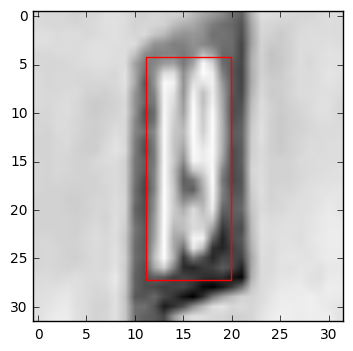

In [869]:
idx=390
fig,ax = plt.subplots(1)
im = svb_validation[idx]
y_pred = model.predict(im.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1),batch_size=1,verbose=0)
ax.imshow(im.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
box = y_pred
rect = patches.Rectangle((box[0][0][0],box[1][0][0]),box[2][0][0],box[3][0][0],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
print(y_pred)

In [870]:
from PIL import Image
from PIL import ImageFilter
import random
test_folders = 'sv_test/test'
SV_IMG_SIZE = 32
SV_CHANNELS = 3
test_imsize = np.ndarray([len(test_data),2])
k = 500
svbt_images = []
max_images = len(test_data)
max_digits = 5
svbtest_labels = np.ones([max_images, max_digits], dtype=int) * 0 
btnboxes = [[] for i in range(max_images)]
print ("%d to load" % len(test_data))
def getBBox(i,perc):
    '''
    Given i, the desired i.png, returns
    x_min, y_min, x_max, y_max,
    the four numbers which define the small rectangular bounding
    box that contains all individual character bounding boxes
    '''
    boxes = test_data[i]['boxes'] 
    x_min=9990
    y_min=9990
    x_max=0
    y_max=0
    for bid,b in enumerate(boxes):
        x_min = b['left'] if b['left'] <= x_min else x_min
        y_min = b['top'] if b['top'] <= y_min else y_min
        x_max = b['left']+b['width'] if  b['left']+b['width'] >= x_max else x_max
        y_max = b['top']+b['height'] if b['top']+b['height'] >= y_max else y_max
    step_x = 0#x_min# (random.random()-0.5)/2*x_min
    step_y = 0#y_min# (random.random()-0.5)/2 *y_min
    dy = y_max-y_min
    dx = x_max-x_min
    dpy = dy*perc
    dpx = dx*perc
    btnboxes[i]=[x_min,y_min,dx,dy]
    return x_min, y_min, x_max, y_max

for i in range(max_images):
    
    print (" \r%d" % i ,end="")
    filename = test_data[i]['filename']
    fullname = os.path.join(test_folders, filename)
    boxes = test_data[i]['boxes']
    label = [0,0,0,0,0]
    lb = len(boxes)
    if lb <= max_digits:
        im = Image.open(fullname)
        x_min, y_min, x_max, y_max = getBBox(i,1)
        nxmax = x_max# if x_max > SV_IMG_SIZE else SV_IMG_SIZE
        nymax = y_max #if y_max > SV_IMG_SIZE else SV_IMG_SIZE
        #im = im.crop([x_min,y_min,nxmax,nymax])
        owidth, oheight = im.size
        wr = SV_IMG_SIZE/float(owidth)
        hr = SV_IMG_SIZE/float(oheight)
        for bid,box in  enumerate(boxes):
            svbtest_labels[i][max_digits-lb+bid] = int(box['label']) 
        box = btnboxes[i]
        box[0]*=wr
        box[1]*=hr
        box[2]*=wr
        box[3]*=hr
        im = im.resize((SV_IMG_SIZE,SV_IMG_SIZE),Image.ANTIALIAS)
        #im = im.filter(ImageFilter.EDGE_ENHANCE_MORE)
        im = im - np.mean(im)
        array = np.asarray(im)
        array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,SV_CHANNELS)).astype(np.float32)
        na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE,1],dtype=int)
        for x in range (array.shape[0]):
            for y in range (array.shape[1]):
                na[x][y]=np.average(array[x][y][:])
        na = na.reshape(SV_IMG_SIZE,SV_IMG_SIZE,1)
        na = na.astype(np.float32)
        na = (na/125.5)-1
        #na = na - np.mean(na)
        #print(array.shape)
        svbt_images.append(na)

#plt.imshow(sv_images[0])

13068 to load
13067

In [871]:
#model = load_model('box_cnn.h5')
print(svbtest_labels.shape)
print(np.asarray(svbt_images).shape)
svb_test_labels = [np.array([i[0] for i in svbtest_labels]),
                             np.array([i[1] for i in svbtest_labels]),
                             np.array([i[2] for i in svbtest_labels]),
                             np.array([i[3] for i in svbtest_labels])]
model.evaluate(np.asarray(svbt_images),svb_test_labels)



(13068, 5)
(13068, 32, 32, 1)
13056/13068 [============================>.] - ETA: 0s

[502.93705113845607,
 147.16032152785999,
 48.450568584188758,
 60.082398480291864,
 247.24376194361048,
 147.16032152785999,
 48.450568584188758,
 60.082398480291864,
 247.24376194361048]

[array([[ 0.80223405]], dtype=float32), array([[ 4.3405261]], dtype=float32), array([[ 4.95924568]], dtype=float32), array([[ 1.1979692]], dtype=float32)]


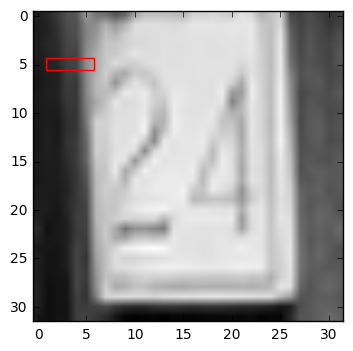

In [872]:
fig,ax = plt.subplots(1)
filename = 'shot1.jpg'
fullname = os.path.join(shot_folder, filename)
img = Image.open(fullname)
img = img.resize((BIG,BIG), Image.ANTIALIAS)
img = img.crop([43,45,75,75])
img = img.resize((SV_IMG_SIZE,SV_IMG_SIZE), Image.ANTIALIAS)
array = np.asarray(img)
array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
for x in range (array.shape[0]):
    for y in range (array.shape[1]):
        na[x][y]=np.average(array[x][y][:])
array = na.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1)
array = (array/125.5)-1

y_pred = model.predict(array,batch_size=1,verbose=0)
ax.imshow(array.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
box = y_pred
rect = patches.Rectangle((box[0][0][0],box[1][0][0]),box[2][0][0],box[3][0][0],linewidth=1,edgecolor='r',facecolor='none')
#rect = patches.Rectangle((5.145,5.05),17.08,17.013)
ax.add_patch(rect)
print(y_pred)

[array([[ 4.4548049]], dtype=float32), array([[ 6.11470652]], dtype=float32), array([[ 7.38529682]], dtype=float32), array([[ 3.24158192]], dtype=float32)]


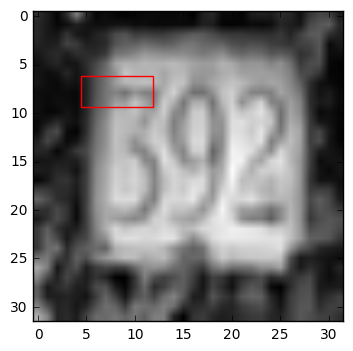

In [873]:
fig,ax = plt.subplots(1)
filename = 'shot2.jpg'
fullname = os.path.join(shot_folder, filename)
img = Image.open(fullname)
img = img.resize((BIG,BIG), Image.ANTIALIAS)
img = img.crop([12,17,45,45])
img = img.resize((SV_IMG_SIZE,SV_IMG_SIZE), Image.ANTIALIAS)
array = np.asarray(img)
array =  array.reshape((SV_IMG_SIZE,SV_IMG_SIZE,3)).astype(np.float32)
na = np.zeros([SV_IMG_SIZE,SV_IMG_SIZE],dtype=int)
for x in range (array.shape[0]):
    for y in range (array.shape[1]):
        na[x][y]=np.average(array[x][y][:])
array = na.reshape(1,SV_IMG_SIZE,SV_IMG_SIZE,1)
array = (array/125.5)-1
y_pred = model.predict(array,batch_size=1,verbose=0)
ax.imshow(array.reshape(SV_IMG_SIZE,SV_IMG_SIZE),cmap='gray')
box = y_pred
rect = patches.Rectangle((box[0][0][0],box[1][0][0]),box[2][0][0],box[3][0][0],linewidth=1,edgecolor='r',facecolor='none')
#rect = patches.Rectangle((5.145,5.05),17.08,17.013)
ax.add_patch(rect)
print(y_pred)

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.